## Goal of notebook

This notebook accompanies [sSVN](https://github.com/leviyevalex/sSVN), and provides an example of how to run on the hybrid Rosenbrock. The hybrid Rosenbrock is a very convenient benchmark.
1. It is easily adapted to any number of dimensions $D \ge 2$.
2. Each marginal is a long and narrow ridge. These are notoriously difficult for sampling algorithms to resolve.
3. It may be analytically sampled, providing a computationally trivial way to compare the quality of samples obtained via various methods/algorithms.
4. Most importantly, it closely resembles many geometries often encountered in practice (e.g, https://arxiv.org/abs/2106.15163).

In this notebook we compare the performance of SVGD and sSVN on a ten-dimensional hybrid Rosenbrock. We encourage the reader to tinker with the settings of the hybrid Rosenbrock, `eps`, and `nParticles`. The reader will find that sSVN is much more stable than sSVGD. That is, sSVN may be evolved with a much larger `eps`.

## Import tools

In [1]:
import sys
sys.path.append("..")

from models.JAXHRD import hybrid_rosenbrock
from jax.lib import xla_bridge
# from models.multivariate_gaussian import multivariate_gaussian
from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples
import numpy as np
%matplotlib inline
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
import corner
from jax import random, devices
import jax.numpy as jnp


In [2]:
print(devices())

print(xla_bridge.get_backend().platform)


INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
[gpu(id=0)]
gpu


## Setup hybrid Rosenbrock model

In [3]:
# Hybrid Rosenbrock
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B)
# bounded_iid_samples = np.load('rosenbrock_iid_bounded_samples.npy')
# Load iid samples
# try:
#     bounded_iid_samples = np.load('rosenbrock_iid_bounded_samples.npy')
# except:
#     np.random.seed(2)
iid_samples = model.newDrawFromPosterior(50000000)
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

39688 samples obtained from rejection sampling


In [14]:
#%%##########################
# Birth death version
#############################
nParticles = 100
h = model.DoF / 10
nIterations = 3000
stride = 101
# Remarks:
# h=1 works well for separated modes
# stride = nIterations / 3, where 3 = number of birth-step steps

bd_kwargs = {'use': False, 
             'kernel_type': 'Lp',
             'p':2,
             'h': .01,
             'start_iter': -1,
             'tau': 0.01,
             'space': 'primal',
             'stride': stride}

sampler1 = samplers(model=model, nIterations=nIterations, nParticles=nParticles, profile=False, kernel_type='Lp', bd_kwargs=bd_kwargs)
kernelKwargs = {'h':h, 'p':2} 

# sampler1.apply(method='MALA', eps=0.001, kernelKwargs=kernelKwargs)
sampler1.apply(method='langevin', eps=0.05, kernelKwargs=kernelKwargs)


# #%%##########################
# # Birth death version
# #############################
# nParticles = 100
# h = model.DoF / 10
# nIterations = 200

# bd_kwargs = {'use': True, 
#              'h': 0.01,
#              'use_metric': False, 
#              'start_iter': -1,
#              'end_iter': nIterations+5,
#              'eps_bd': 0.01,
#              'kernel_type': 'Lp',
#              'p':2}

# sampler1 = samplers(model=model, nIterations=nIterations, nParticles=nParticles, profile=False, kernel_type='Lp', bd_kwargs=bd_kwargs)
# kernelKwargs = {'h':h, 'p':2} 

# sampler1.apply(method='reparam_sSVN', eps=1, kernelKwargs=kernelKwargs)

Stepsize 0.050000 | Median bandwidth: 0.025324 | n_events: 0:   0%|          | 8/3000 [00:00<01:23, 35.71it/s]

Stepsize 0.050000 | Median bandwidth: 0.020135 | n_events: 0: 100%|██████████| 3000/3000 [01:28<00:00, 34.02it/s]


INFO:src.samplers:OUTPUT: Run completed successfully! Data stored in:
 /mnt/c/Users/alex/Documents/sSVN_GW/outdir/1694635897/output_data.h5


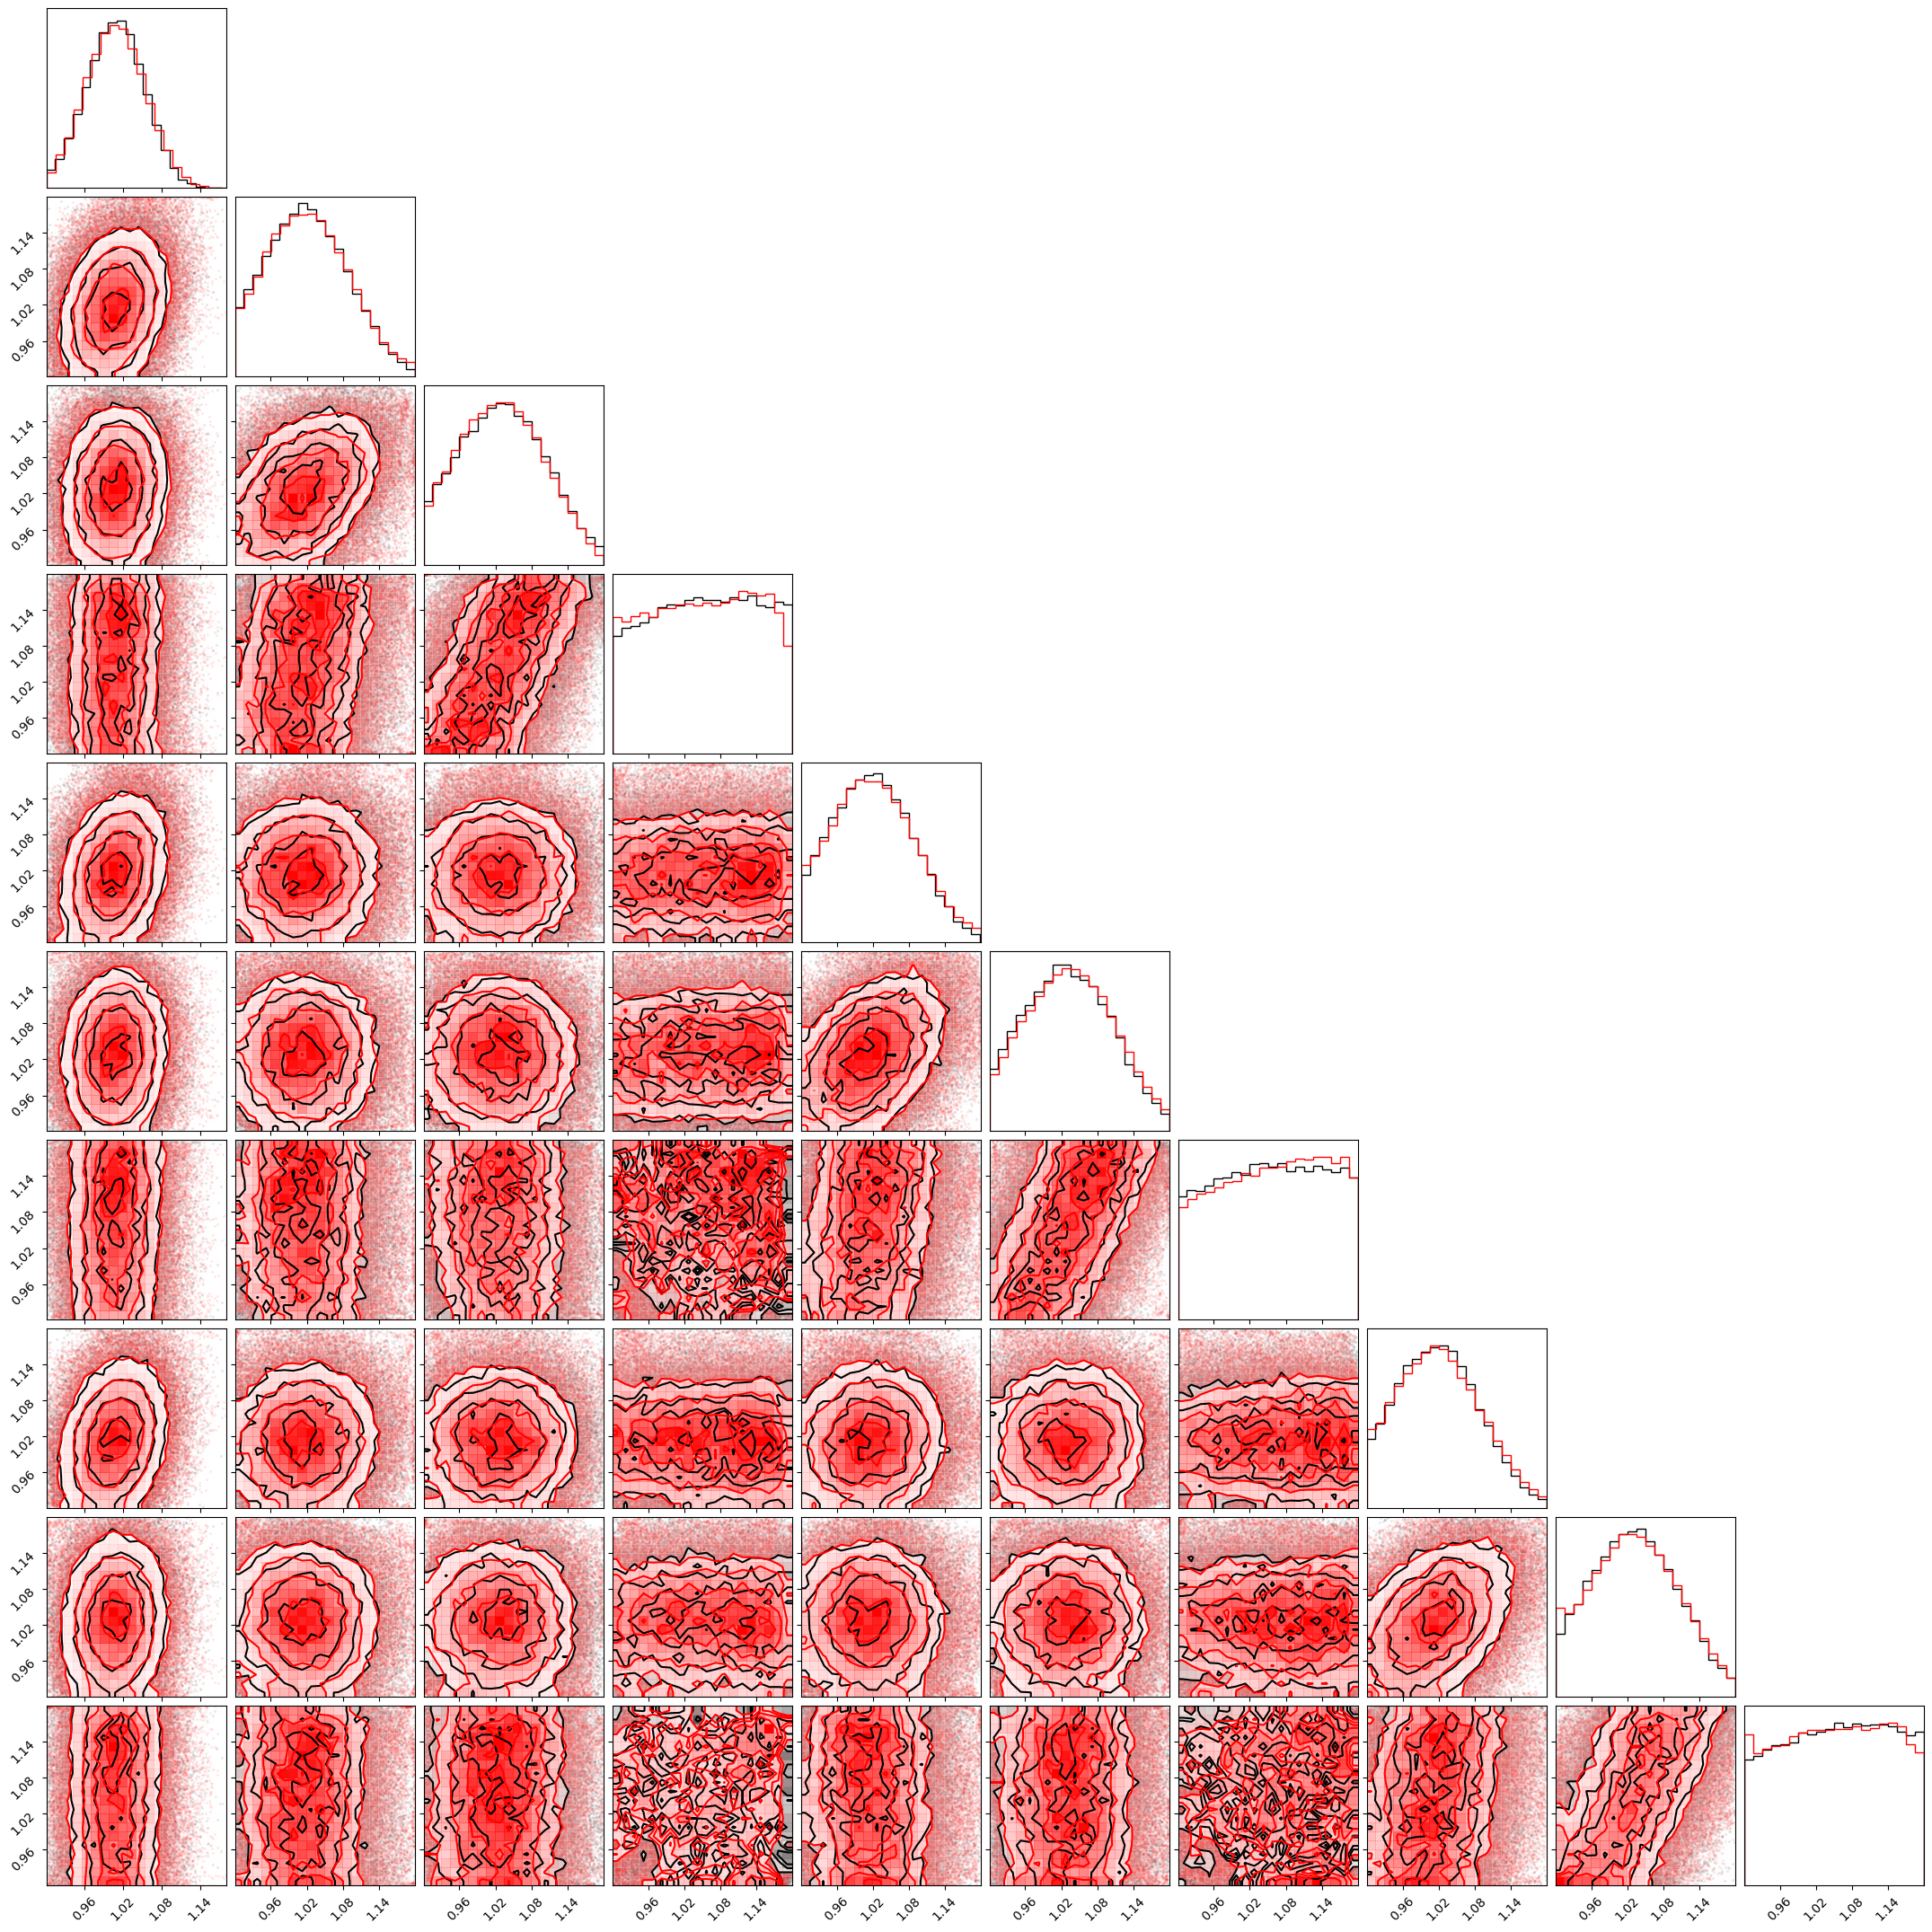

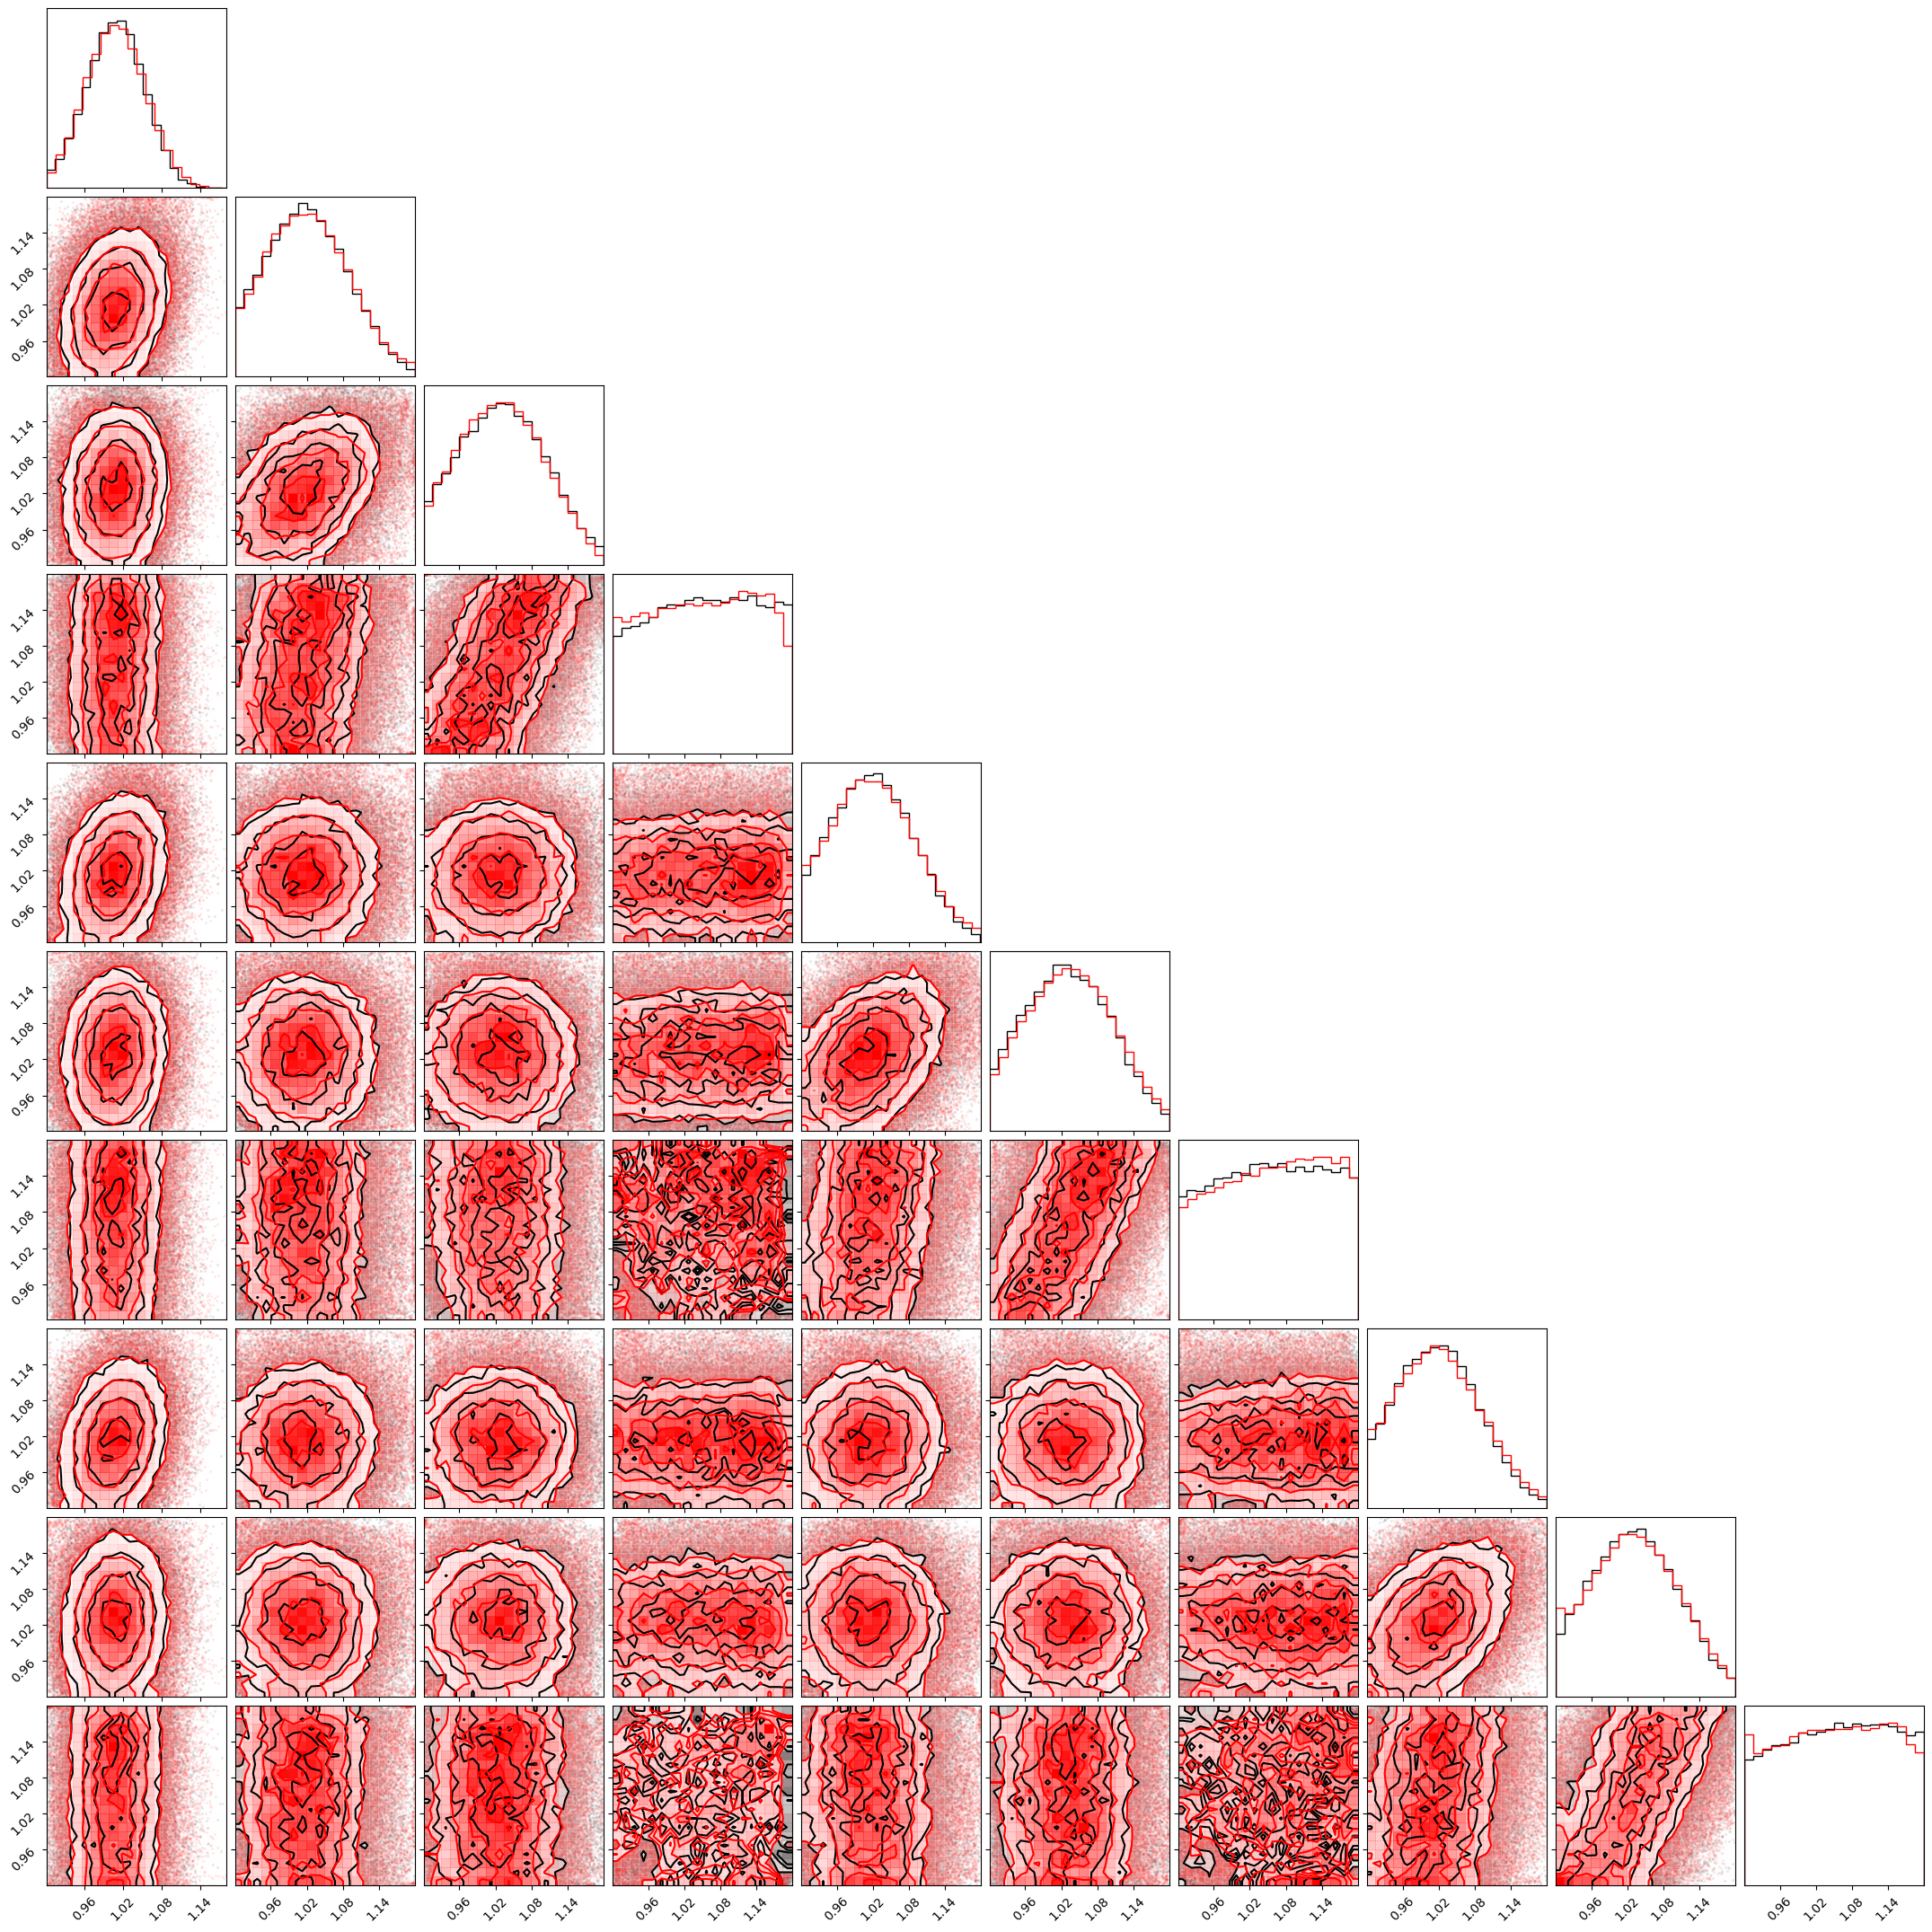

In [15]:
# %%capture
X1 = collect_samples(sampler1.history_path)
fig1 = corner.corner(bounded_iid_samples[0:30000], hist_kwargs={'density':True})
corner.corner(X1, color='r', fig=fig1, hist_kwargs={'density':True})

In [ ]:
nParticles = 100
nIterations = 200
kernelKwargs = {'h':model.DoF / 1, 'p':1.} # Lp
sampler1 = samplers(model=model, nIterations=nIterations, nParticles=nParticles, profile=False, kernel_type='Lp')
schedule = lambda t: 1
# schedule = lambda t: sampler1._cyclic_schedule(t, nIterations, p=1, C=1)
# schedule = lambda t: sampler1._hyperbolic_schedule(t, nIterations, c=1.3, p=5)
# sampler1.apply(method='reparam_sSVN', eps=1, kernelKwargs=kernelKwargs, schedule=schedule)
sampler1.apply(method='reparam_sSVN', eps=1, kernelKwargs=kernelKwargs, schedule=schedule)

In [ ]:
# %%capture
X1 = collect_samples(sampler1.history_path)
fig1 = corner.corner(bounded_iid_samples[0:30000], hist_kwargs={'density':True})
corner.corner(X1, color='r', fig=fig1, hist_kwargs={'density':True})

# Scratchwork

In [ ]:
import matplotlib.pyplot as plt
import h5py
def extract_gmlpt_norm(file, mode='gmlpt_X'):
    with h5py.File(file, 'r') as hf:
        iters_performed = hf['metadata']['L'][()]
        for l in range(iters_performed):
            gmlpt = hf['%i' % l][mode][()]
            if l == 0:
                norm_history = np.zeros(iters_performed)
            norm_history[l] = np.linalg.norm(gmlpt)
        return norm_history
#%%
fig, ax = plt.subplots()
a = extract_gmlpt_norm(sampler1.history_path)
ax.plot(a)

In [ ]:
import h5py
def extract_gmlpt_norm(file, mode='gmlpt_Y'):
    with h5py.File(file, 'r') as hf:
        iters_performed = hf['metadata']['L'][()]
        for l in range(iters_performed):
            gmlpt = hf['%i' % l][mode][()]
            if l == 0:
                norm_history = np.zeros(iters_performed)
            norm_history[l] = np.linalg.norm(gmlpt)
        return norm_history
#%%
fig, ax = plt.subplots()
a = extract_gmlpt_norm(sampler1.history_path, mode='gmlpt_X')
b = extract_gmlpt_norm(sampler1.history_path, mode='gmlpt_Y')
ax.set_xlabel('Iteration')
ax.set_ylabel('<log|g|>')
ax.set_title('Log Average of gradient norms')
ax.plot(np.log(a), label='Primal')
ax.plot(np.log(b), label='Dual')
ax.legend()